In [ ]:
# default_exp dataset

In [ ]:
#export
import albumentations as albu
import copy
import cv2
from skimage.transform import pyramid_gaussian
import numpy as np
from functools import partial
from typing import Tuple

import torch.utils.data as data
from defocus.blurring import hanser_defocus

In [ ]:
#export
class BaseDataset(data.Dataset):
    """Base dataset class."""
    def __init__(self,
                 input_list=None,
                 target_list=None, 
                 forward_process=None,
                 augment=None,
                 corrupt=None,
                 normalize=None,
                 pyramid_levels=1,
                 dim_order='NCHW', #TODO: unused argument, add support for different channel order
                 ):
        """Init function.
        
        Args:
            input_list: 
                a list consisting of the full paths to the input images.                 
                if forward_process_func is not None, this should be the 
                same as the target list. the forward_process_func will 
                be applied to the inputs to simulate actual processes
            target_list: 
                a list consisting of the full paths to the target images.
            forward_process_func:
                if used, the input images are transformed by this function
                to simulate various effects. e.g. they are blurred with a
                hanser_blur function to simulate a defocus blur
            augment: 
                check the example yaml file. these are the augmentations 
                like flips and random crops. applied to input and target
            corrupt: 
                check the example yaml file. these are corruptions like
                noise, blur, jpeg compression. applied to input only
            normalize:
                you would think <who cares?> Seungjun says when
                max_val=255, his models work better. so, yeah.
                note that this does not convert to tensor so if you
                write your own collate_fn, remember that.
            pyramid_levels:
                if you have a multiscale architecture, you need an image
                pyramid. this is how many scales you have in the pyramid
            dim_order:
                maybe someday         
        """
        super(BaseDataset, self).__init__()
        self.input_list = input_list
        self.target_list = target_list
        assert len(self.input_list) == len(self.target_list)
        # get augmentation operators
        # TODO: if .yaml says None, these should just return an identity mapping
        self.augment = get_transformation(augment)
        self.corrupt = get_transformation(corrupt)
        self.normalize = get_transformation(normalize)
        self.pyramid = get_pyramid_generator(pyramid_levels)
        # forward process simulator
        self.forward_process_func = get_forward_process(forward_process)
        # TODO: we may want to both have distorted inputs and 
        # apply a forward_process on top. in the future. maybe.
        if self.forward_process_func is not None:
            self.input_list = self.target_list
        
        self.length = len(self.input_list)
    
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx) -> Tuple:
        # remember that opencv has BGR order so read and convert
        target = cv2.imread(self.target_list[idx])[:,:,::-1]        
        # read the input image or simulate it
        if self.forward_process_func is None:        
            input_ = cv2.imread(self.input_list[idx])[:,:,::-1]
        else:
            input_, target = self.forward_process_func(target)
        
        input_, target = self.augment(input_, target)
        input_ = self.corrupt(input_)
        input_, target = self.normalize(input_, target)
        input_, target = np.transpose(input_, (2, 0, 1)), np.transpose(target, (2, 0, 1))
        # this is to generate an image pyramid, it is an identity function by default
        input_, target = self.pyramid(input_, target)
        return input_, target

In [ ]:
#export
# TODO: tie this scale thing to the image size instead of reading 
# it from the .yaml (maybe?)
def get_forward_process(simulator):
    if simulator is None:
        return None
    kwargs = copy.deepcopy(vars(simulator))
    forward_processes = {'hanser_defocus': hanser_defocus,
                        }
    function_handle = forward_processes[kwargs.pop('type')]
    forward_process = partial(function_handle, **kwargs)
    return forward_process

'''
Here is a lesson: you can't pickle nested functions, they are not in the correct context
https://stackoverflow.com/questions/52265120/python-multiprocessing-pool-attributeerror

So what do you do? 
https://stackoverflow.com/questions/12019961/python-pickling-nested-functions

Basically, this ugly __call__ thingy.

Why bother at all? Lightning uses pytorch uses multiprocesssing uses pickle. 

So this function definition

def get_transformation(augmentation):        
    # this reads the relevant yaml part and 
    # returns an albumentation function   
    def recursive_getattr(_augmentation):
        augmentation = copy.deepcopy(_augmentation)
        # I wanted to use recursion since forever
        # I am sorry and  I won't do it again
        if not hasattr(augmentation, 'transforms'):
            return getattr(albu, vars(augmentation).pop('type'))(**vars(augmentation))
        else:
            func = getattr(albu, vars(augmentation).pop('type'))
            transforms = vars(augmentation).pop('transforms')
            transforms = [recursive_getattr(transform) for transform in transforms]
            if hasattr(augmentation, 'additional_targets'):
                vars(augmentation).pop('additional_targets')                
                return func(**vars(augmentation), additional_targets={'target': 'image'}, transforms=transforms)
            else:
                return func(**vars(augmentation), transforms=transforms)
    # aug_func is the albumentation function e.g. albu.Normalize
    # note that this is a function object with albumentation's kwargs
    aug_func = recursive_getattr(augmentation)

    # I don't like albumentation's kwargs, so this is a wrapper:
    def process(input_, target=None):
        if hasattr(aug_func, 'additional_targets'):
            returned_tuple = aug_func(image=input_, target=target)
            return returned_tuple['image'], returned_tuple['target']
        else:
            return aug_func(image=input_)['image']

    return process
    
becomes the following class:
'''
class get_transformation(object):  
    def __init__(self, augmentation):
        self.augmentation = augmentation
        # aug_func is the albumentation function e.g. albu.Normalize
        # note that this is a function object with albumentation's kwargs
        self.aug_func = self.recursive_getattr(augmentation)        
    # this reads the relevant yaml part and 
    # returns an albumentation function   
    def recursive_getattr(self, _augmentation):
        augmentation = copy.deepcopy(_augmentation)
        # I wanted to use recursion since forever
        # I am sorry and  I won't do it again
        if augmentation is None:
            return None
        if not hasattr(augmentation, 'transforms'):
            return getattr(albu, vars(augmentation).pop('type'))(**vars(augmentation))
        else:
            func = getattr(albu, vars(augmentation).pop('type'))
            transforms = vars(augmentation).pop('transforms')
            transforms = [self.recursive_getattr(transform) for transform in transforms]
            if hasattr(augmentation, 'additional_targets'):
                vars(augmentation).pop('additional_targets')                
                return func(**vars(augmentation), additional_targets={'target': 'image'}, transforms=transforms)
            else:
                return func(**vars(augmentation), transforms=transforms)
            
    def __call__(self, input_, target=None):
        if hasattr(self.aug_func, 'additional_targets'):
            returned_tuple = self.aug_func(image=input_, target=target)
            return returned_tuple['image'], returned_tuple['target']
        elif self.aug_func is not None:
            return self.aug_func(image=input_)['image']
        else:
            return input_

class get_pyramid_generator(object):
    def __init__(self, pyramid_levels):
        self.pyramid_levels = pyramid_levels
        
    def __call__(self, input_, target):
        # if there is no pyramid, just an identity mapping
        if self.pyramid_levels == 1:
            return input_, target
        # sskimage.transform.pyramid_gaussian expects CHW input, so first go back to HWC
        input_ = input_.astype(np.float32).transpose(1,2,0)
        target = target.astype(np.float32).transpose(1,2,0)
        # note the order reversal. we are providing the coarsest image as input_pyramid[0]
        # and the original resolution as the last, i.e. input_pyramid[2]
        input_pyramid = list(pyramid_gaussian(input_, self.pyramid_levels-1, multichannel=True))[::-1]
        target_pyramid = list(pyramid_gaussian(target, self.pyramid_levels-1, multichannel=True))[::-1]

        # convert to tensors
        # ugly, but explicit
        input_ = []
        target = []
        for scaled_input, scaled_target in zip(input_pyramid, target_pyramid):
            # ascontiguousarray is safer before tensor conversions
            scaled_input = np.ascontiguousarray(scaled_input.transpose(2, 0, 1))
            scaled_target = np.ascontiguousarray(scaled_target.transpose(2, 0, 1))
            input_.append(scaled_input)
            target.append(scaled_target)

        return input_, target

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_utilities.ipynb.
Converted 02_architecture_common.ipynb.
Converted 03_architecture_MSResNet.ipynb.
Converted 04_architecture_DeblurGANv2.ipynb.
Converted 05_blurring.ipynb.
Converted 06_dataset.ipynb.
Converted 07_losses.ipynb.
Converted 08_callbacks.ipynb.
Converted 09_model.ipynb.
Converted fuckit.ipynb.


In [ ]:
import argparse
import ruamel_yaml as yaml
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

from defocus.model import Model
from defocus.utilities import Bunch, get_GOPRO_lists
import defocus.callbacks as Callbacks

In [ ]:
parser = argparse.ArgumentParser(description='It is time for more... experiments.')
parser.add_argument('--config_path', type=str, default='configs/config.yaml', help='Experiment configuration')

argv = ['--config_path', '../configs/config.yaml']
args = parser.parse_args(argv)

with open(args.config_path, 'r') as f:
    config = yaml.safe_load(f)
    # Bunch is for **recursively** creating a Namespace from dict object
    bunch = Bunch(config)
    # but lightning must have a Namespace object, so convert to Namespace back again
    args = argparse.Namespace(**vars(bunch))

args = argparse.Namespace(**vars(bunch))

In [ ]:
augs = args.input.validation_corruptions

In [ ]:
augs

In [ ]:
trans = get_transformation(augs)

TypeError: vars() argument must have __dict__ attribute

In [ ]:
input_list, target_list = get_GOPRO_lists(root_folder=args.input.datapath.root_folder,
                                                  image_pair_list=args.input.datapath.image_pair_list
                                                 )

In [ ]:
target = cv2.imread(target_list[0])[:,:,::-1]     
input_ = cv2.imread(input_list[0])[:,:,::-1]  

In [ ]:
trans = get_transformation(augs)

In [ ]:
input_aug, target_aug = trans(input_, target)

In [ ]:
import matplotlib.pyplot as plt

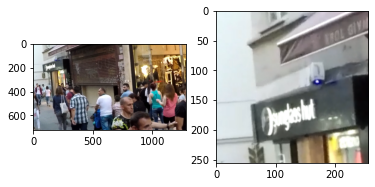

In [ ]:
plt.subplot(121)
plt.imshow(target)
plt.subplot(122)
plt.imshow(target_aug)

In [ ]:
class foo(object):
    def __init__(self, a):
        self.a = a
    def __call__(self, b): # the function formerly known as "bar"
        return self.a + b

In [ ]:
d = {1:foo(1), 2:foo(2)}

In [ ]:
d[1](5), d[2](5)

(6, 7)

In [ ]:
def foo(a):
    def bar(b):
        return a+b
    return bar

In [ ]:
d = {1:foo(1), 2:foo(2)}

In [ ]:
d[1](5), d[2](5)

(6, 7)